<a href="https://colab.research.google.com/github/vsofi3/ADT/blob/main/digits/FinalProjectDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST project using Convolutional Model**

by Sofi Vinas (CIS 472)

Setting up my environment

In [29]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

I've mounted my google drive as it contains my datasets and other colab notebooks

In [30]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


Setting up my hyperparameters

In [31]:
num_epochs = 3
num_classes = 10
training_batch_size = 64
# I'm printing out the tensor below that shows the 1000 test batch
testing_batch_size = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
input_size = 784 # initializing for our logistic regression model

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

**Let's load the data**

In [32]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=training_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=testing_batch_size, shuffle=True)

In [33]:
image_examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(image_examples)

**Test batch tensor**

In [34]:
# Let's look at how our test batch is structured
example_data.shape

torch.Size([1000, 1, 28, 28])

Images paired with their true classification


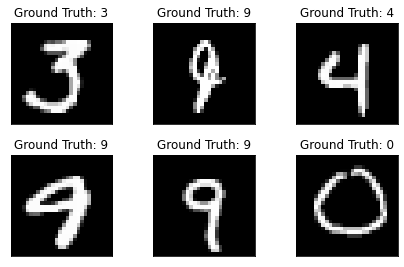

In [35]:
# This means we have 1000 examples of 28x28 pixels in grayscale
# We can use matplotlib to visualize some of this data

figure = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
figure

print("Images paired with their true classification")

https://pytorch.org/vision/stable/models.html

In [36]:
# Let's make a simple logistic regression model (using Logistic Regression class)
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
    
    def forward(self, x): 
        out = self.linear(x) 
        return out 

model2 = LogisticRegression(input_size, num_classes) 
print(model2)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [37]:
# Let's build our bulkier network  
# I'm going to use two 2d convolutional layers with two fully-connected linear layers
# I'm also going to use two dropout layers for regularization

Reference ResNet

https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/

In [38]:
class Convolutional(nn.Module):
    def __init__(self):
        super(Convolutional, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        # making sure our output is 10- matching the number of classes in the dataset

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [39]:
model = Convolutional()
# I'll be using stochastic gradient descent as the optimizer
# And our learning rate remains as 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

# let's look at what the structure of our model is composed of
print(model)

Convolutional(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [40]:
# Let's train with our model
# Loading the individual batches is handled by the DataLoader we imported

# setting up some data structures to hold some important performance results
train_losses = []
test_losses = []
train_counter = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]


# Running the test loop once before starting the training to see what accuracy/loss is achieved just with randomly initialized network parameters
# here we're calling our regular model (convolutional), but we can switch to our logistic regression model to test that one out

def training_loop(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
    if (batch_idx % log_interval == 0):
      print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      # storing our results in .pth files in our results folder in google drive
      # torch.save(model.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [41]:
# setting up our test function

def testing_loop():
  model.eval()
  accurate = 0
  test_loss = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      accurate += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\n Results Below:')
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, accurate, len(test_loader.dataset),
    100. * accurate / len(test_loader.dataset)))

Here I'll be entering the training loop

In [42]:
# with randomly initialized network parameters

# call our test function from above
testing_loop()
for epoch in range(1, num_epochs + 1):
  training_loop(epoch)
  testing_loop()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Results Below:

Test set: Average loss: 2.3105, Accuracy: 973/10000 (10%)

Training Epoch: 1 [0/60000 (0%)]	Loss: 2.302462
Training Epoch: 1 [640/60000 (1%)]	Loss: 2.284884
Training Epoch: 1 [1280/60000 (2%)]	Loss: 2.303247
Training Epoch: 1 [1920/60000 (3%)]	Loss: 2.275234
Training Epoch: 1 [2560/60000 (4%)]	Loss: 2.283003
Training Epoch: 1 [3200/60000 (5%)]	Loss: 2.257317
Training Epoch: 1 [3840/60000 (6%)]	Loss: 2.255617
Training Epoch: 1 [4480/60000 (7%)]	Loss: 2.277248
Training Epoch: 1 [5120/60000 (9%)]	Loss: 2.239959
Training Epoch: 1 [5760/60000 (10%)]	Loss: 2.183639
Training Epoch: 1 [6400/60000 (11%)]	Loss: 2.202755
Training Epoch: 1 [7040/60000 (12%)]	Loss: 2.133589
Training Epoch: 1 [7680/60000 (13%)]	Loss: 1.995432
Training Epoch: 1 [8320/60000 (14%)]	Loss: 2.021953
Training Epoch: 1 [8960/60000 (15%)]	Loss: 1.939861
Training Epoch: 1 [9600/60000 (16%)]	Loss: 1.929582
Training Epoch: 1 [10240/60000 (17%)]	Loss: 1.679256
Training Epoch: 1 [10880/60000 (18%)]	Loss: 1.79529

Convolutional Model Performance



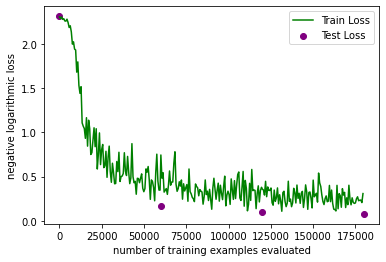

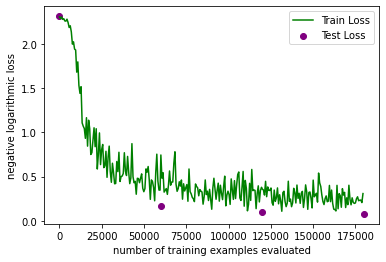

In [43]:
# Let's set up a graph to see the model's performance (visually)
print("Convolutional Model Performance\n")

graph = plt.figure()
# let's make the graph joker themed for the new batman movie!
plt.plot(train_counter, train_losses, color='green')
plt.scatter(test_counter, test_losses, color='purple')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples evaluated')
plt.ylabel('negative logarithmic loss')
graph

In [44]:
with torch.no_grad():
  output = model(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Our Model Predictions


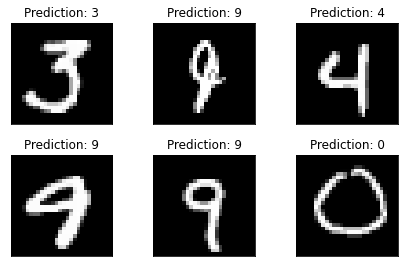

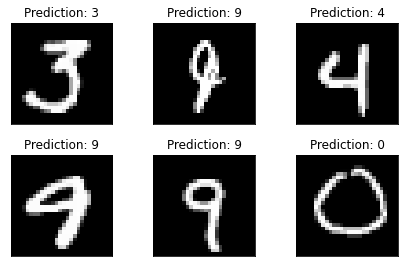

In [45]:
print("Our Model Predictions")

graph2 = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
graph2

So in this case, we got lucky and our model was able to accurately predict every digit. Very cool!